c:\Users\Hp\miniconda3\envs\RemoteSensing\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Explained variance ratio: [0.69856095 0.26269943 0.01760479]
Total explained variance: 0.97886515
Silhouette score: 0.5017831325531006
Davies–Bouldin index: 0.8186116875149062


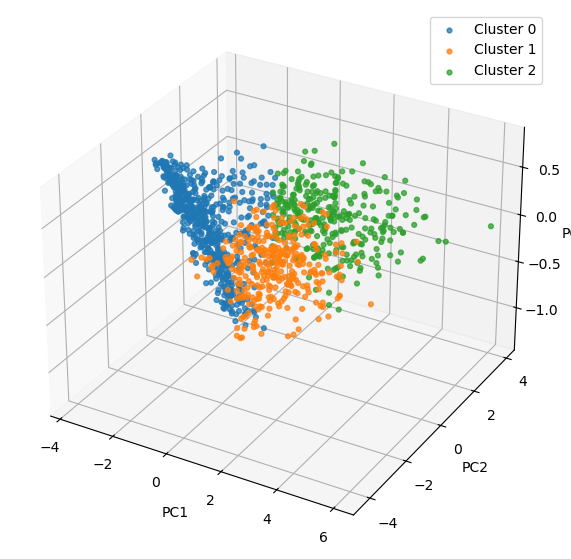

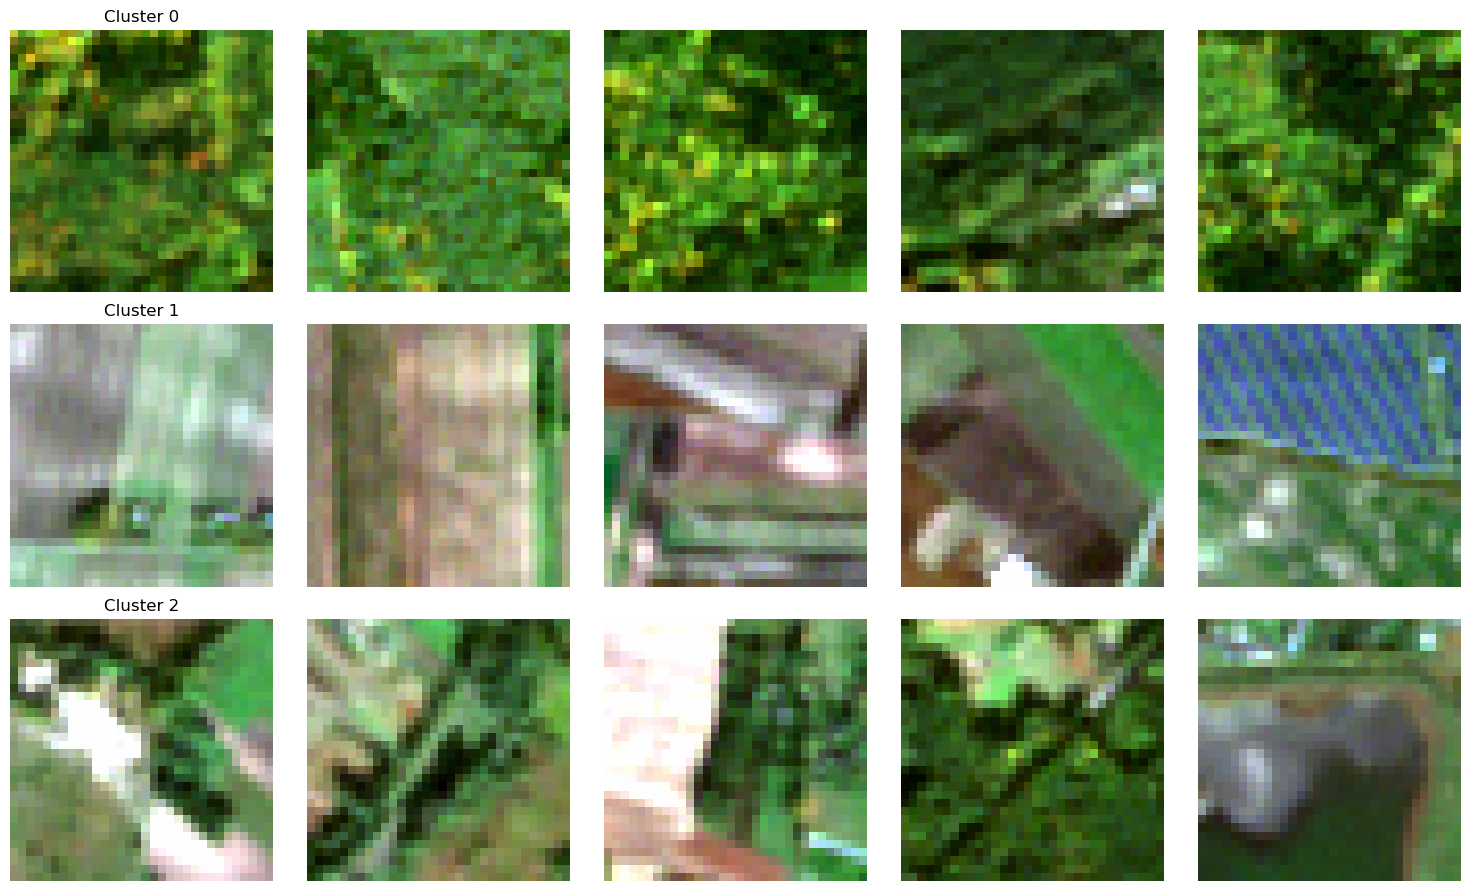


Cluster 0
mean per band: [0.2078 0.3049 0.0965]
std per band: [0.0838 0.0969 0.0532]

Cluster 1
mean per band: [0.5877 0.642  0.5453]
std per band: [0.1265 0.1171 0.1354]

Cluster 2
mean per band: [0.4021 0.4873 0.3292]
std per band: [0.1995 0.1891 0.2064]


In [7]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import tensorflow as tf
from tensorflow.keras import layers, models

TIF_PATH = "vegetation.tif"
PATCH_SIZE = 32
N_PATCHES = 1200
N_CLUSTERS = 3
RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

with rasterio.open(TIF_PATH) as src:
    img = src.read()
    nodata = src.nodata

img = np.moveaxis(img, 0, -1)
img = img.astype(np.float32)

eps = 1e-6
for b in range(img.shape[-1]):
    p99 = np.percentile(img[..., b], 99)
    if p99 < eps:
        p99 = 1.0
    img[..., b] = np.clip(img[..., b] / p99, 0, 1)

H, W, C = img.shape
half = PATCH_SIZE // 2

if H < PATCH_SIZE or W < PATCH_SIZE:
    raise ValueError("Image too small for selected patch size.")

patches = []
centers = []

tries = 0
max_tries = N_PATCHES * 50

while len(patches) < N_PATCHES and tries < max_tries:
    tries += 1
    y = np.random.randint(half, H - half)
    x = np.random.randint(half, W - half)
    patch = img[y-half:y+half, x-half:x+half, :]
    if np.allclose(patch, 0):
        continue
    patches.append(patch)
    centers.append((y, x))

patches = np.array(patches)

if len(patches) < 50:
    raise RuntimeError("Too few valid patches extracted.")

feat_mean = patches.mean(axis=(1, 2))
feat_std = patches.std(axis=(1, 2))
X = np.concatenate([feat_mean, feat_std], axis=1)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, n_init="auto")
labels = kmeans.fit_predict(X_std)

pca = PCA(n_components=3, random_state=RANDOM_SEED)
Z = pca.fit_transform(X_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

sil = silhouette_score(Z, labels)
dbi = davies_bouldin_score(Z, labels)

print("Silhouette score:", sil)
print("Davies–Bouldin index:", dbi)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for cls in range(N_CLUSTERS):
    idx = labels == cls
    ax.scatter(Z[idx, 0], Z[idx, 1], Z[idx, 2], s=12, alpha=0.75, label=f"Cluster {cls}")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

n_show = 5
fig, axes = plt.subplots(N_CLUSTERS, n_show, figsize=(3*n_show, 3*N_CLUSTERS))

if N_CLUSTERS == 1:
    axes = np.array([axes])

for cls in range(N_CLUSTERS):
    idx = np.where(labels == cls)[0]
    if len(idx) == 0:
        for j in range(n_show):
            axes[cls, j].axis("off")
        continue
    pick = np.random.choice(idx, size=min(n_show, len(idx)), replace=False)
    for j in range(n_show):
        axp = axes[cls, j]
        axp.axis("off")
        if j >= len(pick):
            continue
        p = patches[pick[j]]
        if C >= 3:
            rgb = p[..., :3]
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
            axp.imshow(rgb)
        else:
            axp.imshow(p[..., 0], cmap="gray")
        if j == 0:
            axp.set_title(f"Cluster {cls}")

plt.tight_layout()
plt.show()

centroids_std = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_std)

cent_mean = centroids[:, :C]
cent_std = centroids[:, C:]

for cls in range(N_CLUSTERS):
    print(f"\nCluster {cls}")
    print("mean per band:", np.round(cent_mean[cls], 4))
    print("std per band:", np.round(cent_std[cls], 4))


Epoch 1/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - loss: 0.0147 - val_loss: 0.0039
Epoch 2/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 3/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 4/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/8
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - loss: 0.0017 - val_loss: 0.0018

=== Quantitative comparison ===
Bicubic  PSNR: 26.647 dB | SSIM: 0.8074
AutoEnc  PSNR: 20.801 dB | SSIM: 0.7861


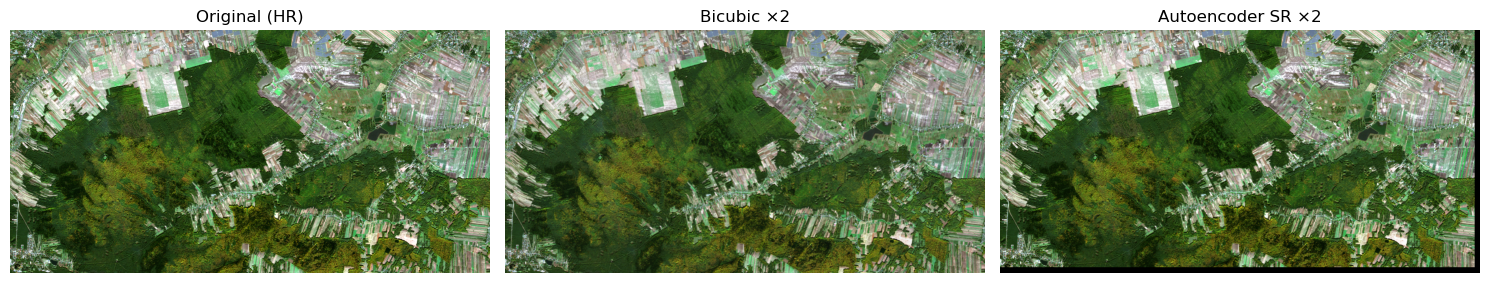

In [8]:
import numpy as np
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

TIF_PATH = "vegetation.tif"
SCALE = 2
PATCH = 64
N_PATCHES = 2000
BATCH = 16
EPOCHS = 8
SEED = 0

np.random.seed(SEED)
tf.random.set_seed(SEED)

with rasterio.open(TIF_PATH) as src:
    img = src.read()
img = np.moveaxis(img, 0, -1).astype(np.float32)

eps = 1e-6
for b in range(img.shape[-1]):
    p99 = np.percentile(img[..., b], 99)
    if p99 < eps:
        p99 = 1.0
    img[..., b] = np.clip(img[..., b] / p99, 0, 1)

H, W, C = img.shape

def make_lr_hr_pairs(img, n_patches, patch, scale):
    H, W, C = img.shape
    hr_list, lr_list = [], []
    for _ in range(n_patches):
        y = np.random.randint(0, H - patch)
        x = np.random.randint(0, W - patch)
        hr = img[y:y+patch, x:x+patch, :]
        if np.allclose(hr, 0):
            continue
        hr_tf = tf.convert_to_tensor(hr[None, ...], dtype=tf.float32)
        lr_small = tf.image.resize(hr_tf, (patch//scale, patch//scale), method="area")
        lr_up = tf.image.resize(lr_small, (patch, patch), method="bicubic")
        hr_list.append(hr)
        lr_list.append(lr_up.numpy()[0])
    return np.stack(lr_list), np.stack(hr_list)

lr_train, hr_train = make_lr_hr_pairs(img, N_PATCHES, PATCH, SCALE)

split = int(0.9 * len(lr_train))
lr_tr, hr_tr = lr_train[:split], hr_train[:split]
lr_va, hr_va = lr_train[split:], hr_train[split:]

inp = layers.Input(shape=(PATCH, PATCH, C))
x = layers.Conv2D(64, 3, padding="same", activation="relu")(inp)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.UpSampling2D()(x)

x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
res = layers.Conv2D(C, 3, padding="same")(x)

out = layers.Add()([inp, res])
out = layers.Activation("sigmoid")(out)

model = models.Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

model.fit(
    lr_tr, hr_tr,
    validation_data=(lr_va, hr_va),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1
)

def sr_full_image(img, scale, patch):
    H, W, C = img.shape
    img_tf = tf.convert_to_tensor(img[None, ...], dtype=tf.float32)
    lr_small = tf.image.resize(img_tf, (H//scale, W//scale), method="area")
    lr_up = tf.image.resize(lr_small, (H, W), method="bicubic").numpy()[0]

    sr = np.zeros_like(lr_up)
    w = np.zeros((H, W, 1))

    step = patch // 2
    for y in range(0, H - patch + 1, step):
        for x in range(0, W - patch + 1, step):
            tile = lr_up[y:y+patch, x:x+patch, :]
            pred = model(tile[None, ...], training=False).numpy()[0]
            sr[y:y+patch, x:x+patch, :] += pred
            w[y:y+patch, x:x+patch, :] += 1

    sr /= np.maximum(w, 1)
    return lr_up, sr

bicubic_up, sr_img = sr_full_image(img, SCALE, PATCH)

psnr_bic = tf.reduce_mean(tf.image.psnr(img, bicubic_up, max_val=1.0)).numpy()
psnr_sr  = tf.reduce_mean(tf.image.psnr(img, sr_img, max_val=1.0)).numpy()
ssim_bic = tf.reduce_mean(tf.image.ssim(img, bicubic_up, max_val=1.0)).numpy()
ssim_sr  = tf.reduce_mean(tf.image.ssim(img, sr_img, max_val=1.0)).numpy()

print("\n=== Quantitative comparison ===")
print(f"Bicubic  PSNR: {psnr_bic:.3f} dB | SSIM: {ssim_bic:.4f}")
print(f"AutoEnc  PSNR: {psnr_sr:.3f} dB | SSIM: {ssim_sr:.4f}")

def show(img, title):
    if img.shape[-1] >= 3:
        rgb = img[..., :3]
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
        plt.imshow(rgb)
    else:
        plt.imshow(img[..., 0], cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
show(img, "Original (HR)")
plt.subplot(1,3,2)
show(bicubic_up, f"Bicubic ×{SCALE}")
plt.subplot(1,3,3)
show(sr_img, f"Autoencoder SR ×{SCALE}")
plt.tight_layout()
plt.show()


###  How can you make it work better?

Increase number of training patches
Replace simple autoencoder with U-Net or residual SR network
Use more realistic LR degradation (blur + noise)
Combine MSE with SSIM or edge-based loss
Train using multi-scene EO imagery instead of a single raster